In [23]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        #return np.exp(x)/(np.sum(np.exp(x),axis=1)[:,None])
        return (np.exp(x)/(np.sum(np.exp(x))))
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return (a * (1 - a))
    
    def __ReLU(self,x):
        return np.vectorize(lambda x:x if x>0 else 0)(x)
    
    def __ReLU_deriv(self,a):
        #a = ReLU()
        return np.vectorize(lambda x:1 if x>0 else 0)(a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if (mode=='train' and self.dropout>0):
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=input.shape)/(1-self.dropout)
            lin_output = np.dot(self.dropout_vector*input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        self.grad_W = (np.atleast_2d(self.dropout_vector*self.input if self.dropout>0 else self.input).T.dot(np.atleast_2d(delta)))
        self.grad_b = delta
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        self.mode = 'train'
    
    def test(self):
        self.mode = 'test'

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y*np.log(y_hat)
        loss = -np.sum(error)
        delta = (y_hat-y)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.train()
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                else:
                    loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        self.test()
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output
    
    def optimize(self, X, y, learning_rate=0.01, test_size=0.25, epochs=10, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        losses = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        
        for e in range(epochs):
            loss=np.zeros(X_train.shape[0])         
            
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            
            # Calculate train and Test Accuracy
            accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
            accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
            
            self.train()
            for it in range(X_train.shape[0]):
                i=np.random.randint(X_train.shape[0])
                
                
                # forward pass
                y_hat = self.forward(X_train[i])

                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta = self.criterion_CELoss(y_train[i],y_hat)
                else:
                    loss[it],delta = self.criterion_MSE(y_train[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
                
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            accuracies_val.append(accuracy_train)
            accuracies_test.append(accuracy_val)
            
            if verbose:
                print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                      format(e, accuracy_train, accuracy_val, np.mean(loss)))
            
            losses[e] = np.mean(loss)
        return losses, accuracies_val, accuracies_test

Epoch: 0..
train Accuracy: 0.10715555555555556 
Validation Accuracy: 0.10946666666666667 
Loss: 0.516737502994927 

Epoch: 1..
train Accuracy: 0.8626444444444444 
Validation Accuracy: 0.8356666666666667 
Loss: 0.36576005756277613 

Epoch: 2..
train Accuracy: 0.8643555555555555 
Validation Accuracy: 0.8460666666666666 
Loss: 0.3395176883995654 

Epoch: 3..
train Accuracy: 0.8826888888888889 
Validation Accuracy: 0.855 
Loss: 0.321511635780709 

Epoch: 4..
train Accuracy: 0.8842444444444445 
Validation Accuracy: 0.8560666666666666 
Loss: 0.3025721833415451 

Epoch: 5..
train Accuracy: 0.8891555555555556 
Validation Accuracy: 0.8573333333333333 
Loss: 0.29201617236097993 

Epoch: 6..
train Accuracy: 0.891 
Validation Accuracy: 0.8511333333333333 
Loss: 0.287170439842203 

Epoch: 7..
train Accuracy: 0.8973111111111111 
Validation Accuracy: 0.8583333333333333 
Loss: 0.28100387084776446 

Epoch: 8..
train Accuracy: 0.8994 
Validation Accuracy: 0.858 
Loss: 0.2780226923084962 

Epoch: 9..
tra

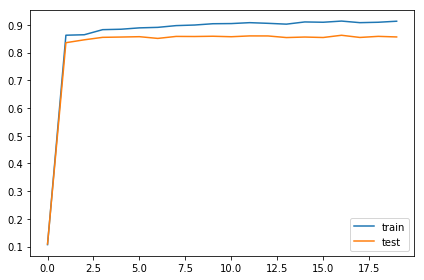

In [2]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0, 0, 0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.01,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

In [ ]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.2, 0.2, 0.2, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.03,epochs=3)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

Epoch: 0..
train Accuracy: 0.09317777777777778 
Validation Accuracy: 0.09433333333333334 
Loss: 1.412792924963113 



In [5]:
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers, metrics, Sequential

import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

y = label
X = data

y_dummies = np.array(pd.get_dummies(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=0.25, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [3]:
import tensorflow
import keras
config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tensorflow.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1179522318103186630
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6671596257
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13570813033383727892
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [17]:
sgd = optimizers.SGD(lr=0.03)
model = Sequential()
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
model.fit(X_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
45000/45000 [==============================] - 90s 2ms/step - loss: 0.7122 - acc: 0.7556 - categorical_accuracy: 0.7556
Epoch 2/3
45000/45000 [==============================] - 90s 2ms/step - loss: 0.5508 - acc: 0.8085 - categorical_accuracy: 0.8085
Epoch 3/3
45000/45000 [==============================] - 91s 2ms/step - loss: 0.5362 - acc: 0.8150 - categorical_accuracy: 0.8150


In [19]:
yhat_val = model.predict(X_val)

In [20]:
accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

In [21]:
accuracy_val

0.8424